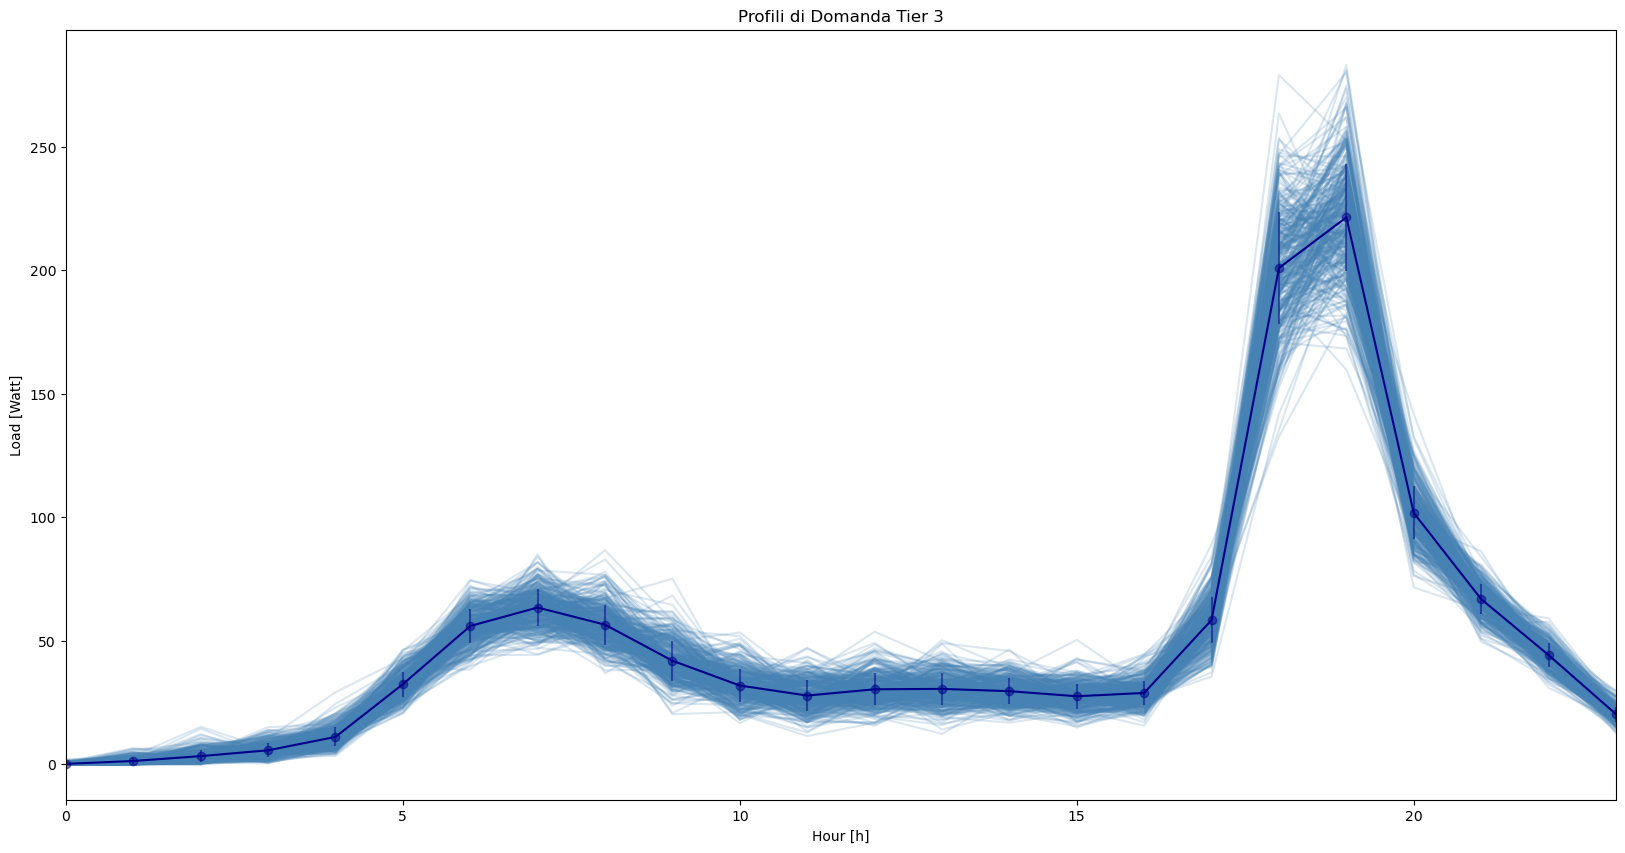

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Caricamento del file Excel
df = pd.read_excel(
    "C:/Users/margh/Desktop/tesi/pypsa-distribution/resources/ramp/daily_type_demand_Tier3.xlsx"
)
df3 = pd.read_excel(
    "C:/Users/margh/Desktop/tesi/pypsa-distribution/resources/ramp/daily_demand_Tier3.xlsx"
)

# Creazione del grafico
fig, ax = plt.subplots(figsize=(20, 10))

# Traccia le curve con etichette per la legenda
df3.plot(
    ax=ax, label="Daily Demand Profile", legend=False, color="steelblue", alpha=0.2
)
df["mean"].plot(ax=ax, label="Mean Demand Profile", legend=False, color="darkblue")
ax.errorbar(
    df.index,
    df["mean"],
    yerr=df["std"],
    fmt="o",
    color="darkblue",
    alpha=0.5,
    label="Deviazione Standard",
)
# Aggiungi etichette agli assi
ax.set_xlabel("Hour [h]")
ax.set_ylabel("Load [Watt]")

# Imposta i limiti dell'asse X per mostrare dalle ore 0 alle ore 24
ax.set_xlim(0, 23)

ax.set_title("Profili di Domanda Tier 3")


# Mostra il grafico
plt.show()

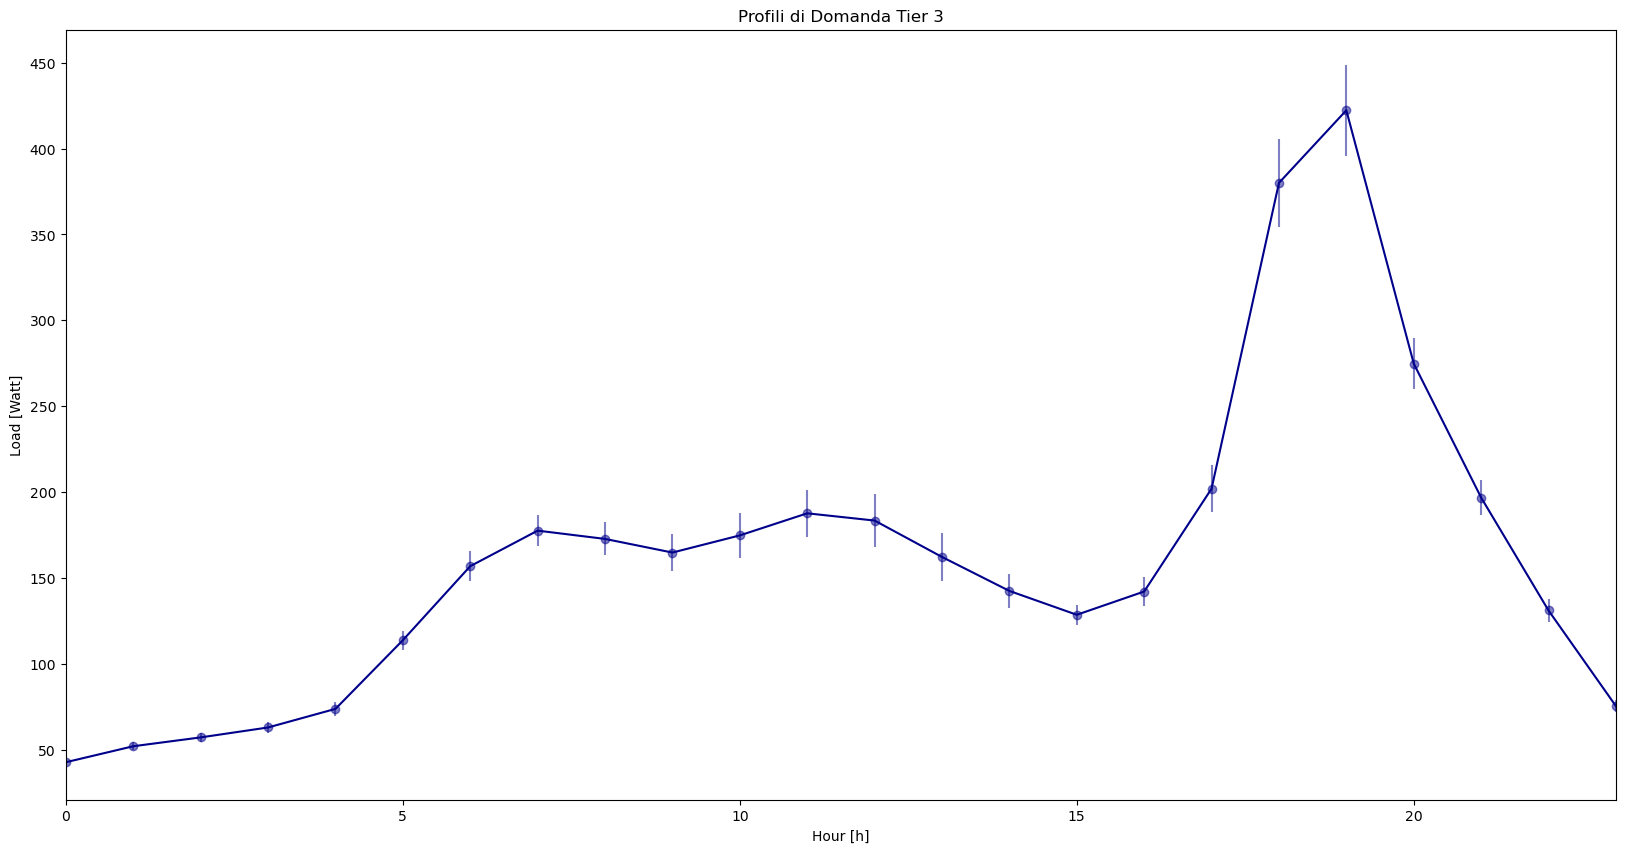

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Caricamento del file Excel
df = pd.read_excel(
    "C:/Users/margh/Desktop/tesi/pypsa-distribution/resources/ramp/daily_type_demand_Tier5.xlsx"
)
df3 = pd.read_excel(
    "C:/Users/margh/Desktop/tesi/pypsa-distribution/resources/ramp/daily_demand_Tier1.xlsx"
)

# Creazione del grafico
fig, ax = plt.subplots(figsize=(20, 10))

# Traccia le curve con etichette per la legenda
df["mean"].plot(ax=ax, label="Mean Demand Profile", legend=False, color="darkblue")
ax.errorbar(
    df.index,
    df["mean"],
    yerr=df["std"],
    fmt="o",
    color="darkblue",
    alpha=0.5,
    label="Deviazione Standard",
)
# Aggiungi etichette agli assi
ax.set_xlabel("Hour [h]")
ax.set_ylabel("Load [Watt]")

# Imposta i limiti dell'asse X per mostrare dalle ore 0 alle ore 24
ax.set_xlim(0, 23)

ax.set_title("Profili di Domanda Tier 3")


# Mostra il grafico
plt.show()

In [4]:
df["mean"].sum()

3876.3945692063958

In [5]:
import numpy as np
import geopandas as gpd
import pandas as pd

cleaned_buildings = gpd.read_file(
    "C:/Users/margh/Desktop/tesi/pypsa-distribution/resources/buildings/cluster_with_buildings.geojson"
)
house = cleaned_buildings[cleaned_buildings["tags_building"] == "house"]
area_tot = house["area_m2"].sum()

pop_microgrid = 1500
density = pop_microgrid / area_tot

grouped_buildings = cleaned_buildings.groupby("cluster_id")
clusters = np.sort(cleaned_buildings["cluster_id"].unique())
house_area_for_cluster = []
for cluster in clusters:
    cluster_buildings = pd.DataFrame(grouped_buildings.get_group(cluster))
    house = cluster_buildings[cluster_buildings["tags_building"] == "house"]
    area_house = house["area_m2"].sum()
    house_area_for_cluster.append(area_house)

population_df = pd.DataFrame()
population_df["cluster"] = clusters
population_df.set_index("cluster", inplace=True)
population_df["house_area_for_cluster"] = house_area_for_cluster
people_for_cluster = (population_df["house_area_for_cluster"] * density).round()
population_df["people_for_cluster"] = people_for_cluster
tier_percent = [0.3, 0.2, 0.2, 0.15, 0.1, 0.05]
people_for_cluster = population_df["people_for_cluster"]
tier_pop_df = population_df["people_for_cluster"].apply(
    lambda x: pd.Series([x * y for y in tier_percent])
)
demand_tier_1 = pd.read_excel(
    "C:/Users/margh/Desktop/tesi/pypsa-distribution/resources/ramp/daily_type_demand_Tier1.xlsx"
)
demand_tier_2 = pd.read_excel(
    "C:/Users/margh/Desktop/tesi/pypsa-distribution/resources/ramp/daily_type_demand_Tier2.xlsx"
)
demand_tier_3 = pd.read_excel(
    "C:/Users/margh/Desktop/tesi/pypsa-distribution/resources/ramp/daily_type_demand_Tier3.xlsx"
)
demand_tier_4 = pd.read_excel(
    "C:/Users/margh/Desktop/tesi/pypsa-distribution/resources/ramp/daily_type_demand_Tier4.xlsx"
)
demand_tier_5 = pd.read_excel(
    "C:/Users/margh/Desktop/tesi/pypsa-distribution/resources/ramp/daily_type_demand_Tier5.xlsx"
)
mean_demand_tier_df = pd.DataFrame()

demand_tiers = [
    demand_tier_1,
    demand_tier_2,
    demand_tier_3,
    demand_tier_4,
    demand_tier_5,
]
for i, demand_tier in enumerate(demand_tiers, start=1):
    mean_column_name = f"tier_{i}"
    mean_demand_tier_df[mean_column_name] = demand_tier["mean"]
mean_demand_tier_df.insert(0, "tier_0", np.zeros(len(mean_demand_tier_df)))

hours_index = pd.date_range(
    start="00:00:00", periods=len(mean_demand_tier_df), freq="H", normalize=True
)
mean_demand_tier_df.index = hours_index.time


std_demand_tier_df = pd.DataFrame()

for i, demand_tier in enumerate(demand_tiers, start=1):
    mean_column_name = f"tier_{i}"
    std_demand_tier_df[mean_column_name] = demand_tier["std"]
std_demand_tier_df.insert(0, "tier_0", np.zeros(len(mean_demand_tier_df)))

std_demand_tier_df.index = hours_index.time

result_dict = {}
for k in range(len(tier_pop_df)):
    pop_cluster = tier_pop_df.iloc[k, :]
    nome_dataframe = f"bus_{k}"
    load_df = pd.DataFrame()
    std_df = pd.DataFrame()
    for j in range(len(pop_cluster)):
        n_person = (
            int(pop_cluster[j]) / 7
        )  # 7 is use to scale from number of people to number of household
        mean_load_person = mean_demand_tier_df.iloc[:, j].values
        mean_load = pd.Series(n_person * mean_load_person)

        sqrt_n_person = np.sqrt(n_person)
        std_load_person = std_demand_tier_df.iloc[:, j].values
        std_load = np.random.normal(mean_load_person, std_load_person) * sqrt_n_person
        std_total = pd.Series(std_load)

        total_load = pd.Series(mean_load.values + std_total.values) / 1000000
        load_df[f"tier_{j}"] = total_load

    result_dict[nome_dataframe] = load_df

C:\Users\margh\AppData\Local\Temp\ipykernel_5236\2213145842.py:51: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours_index = pd.date_range(


In [6]:
tier_pop_df

,0,1,2,3,4,5
cluster,,,,,,
0,42.9,28.6,28.6,21.45,14.3,7.15
1,39.6,26.4,26.4,19.80,13.2,6.60
2,43.8,29.2,29.2,21.90,14.6,7.30
3,41.1,27.4,27.4,20.55,13.7,6.85
4,42.6,28.4,28.4,21.30,14.2,7.10
5,26.1,17.4,17.4,13.05,8.7,4.35
6,51.3,34.2,34.2,25.65,17.1,8.55
7,54.0,36.0,36.0,27.00,18.0,9.00
8,55.5,37.0,37.0,27.75,18.5,9.25


In [15]:
tot_pop = tier_pop_df.sum()
tot_pop

0    450.30
1    300.20
2    300.20
3    225.15
4    150.10
5     75.05
dtype: float64

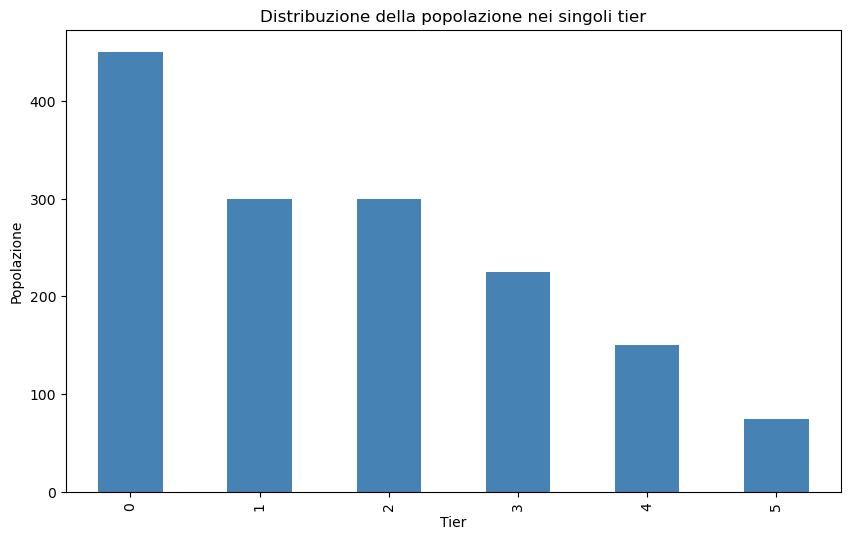

In [16]:
import matplotlib.pyplot as plt

# Seleziona l'ultima riga del DataFrame
ultima_riga = tot_pop

# Crea un grafico a barre
fig, ax = plt.subplots(figsize=(10, 6))
ultima_riga.plot(kind="bar", ax=ax, color="steelblue")

# Aggiungi le etichette degli assi
ax.set_xlabel("Tier")
ax.set_ylabel("Popolazione")

# Imposta il titolo del grafico
ax.set_title("Distribuzione della popolazione nei singoli tier")

# Mostra il grafico
plt.show()

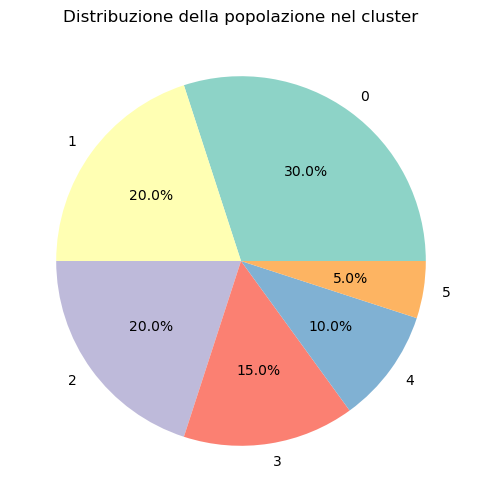

In [12]:
import matplotlib.pyplot as plt

# Seleziona l'ultima riga del DataFrame
ultima_riga = tot_pop

# Crea un grafico a torta con una palette di colori migliorata
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.get_cmap("Set3").colors
ax.pie(ultima_riga, labels=ultima_riga.index, autopct="%1.1f%%", colors=colors)

# Imposta il titolo del grafico
ax.set_title("Distribuzione della popolazione nel cluster")

# Mostra il grafico
plt.show()

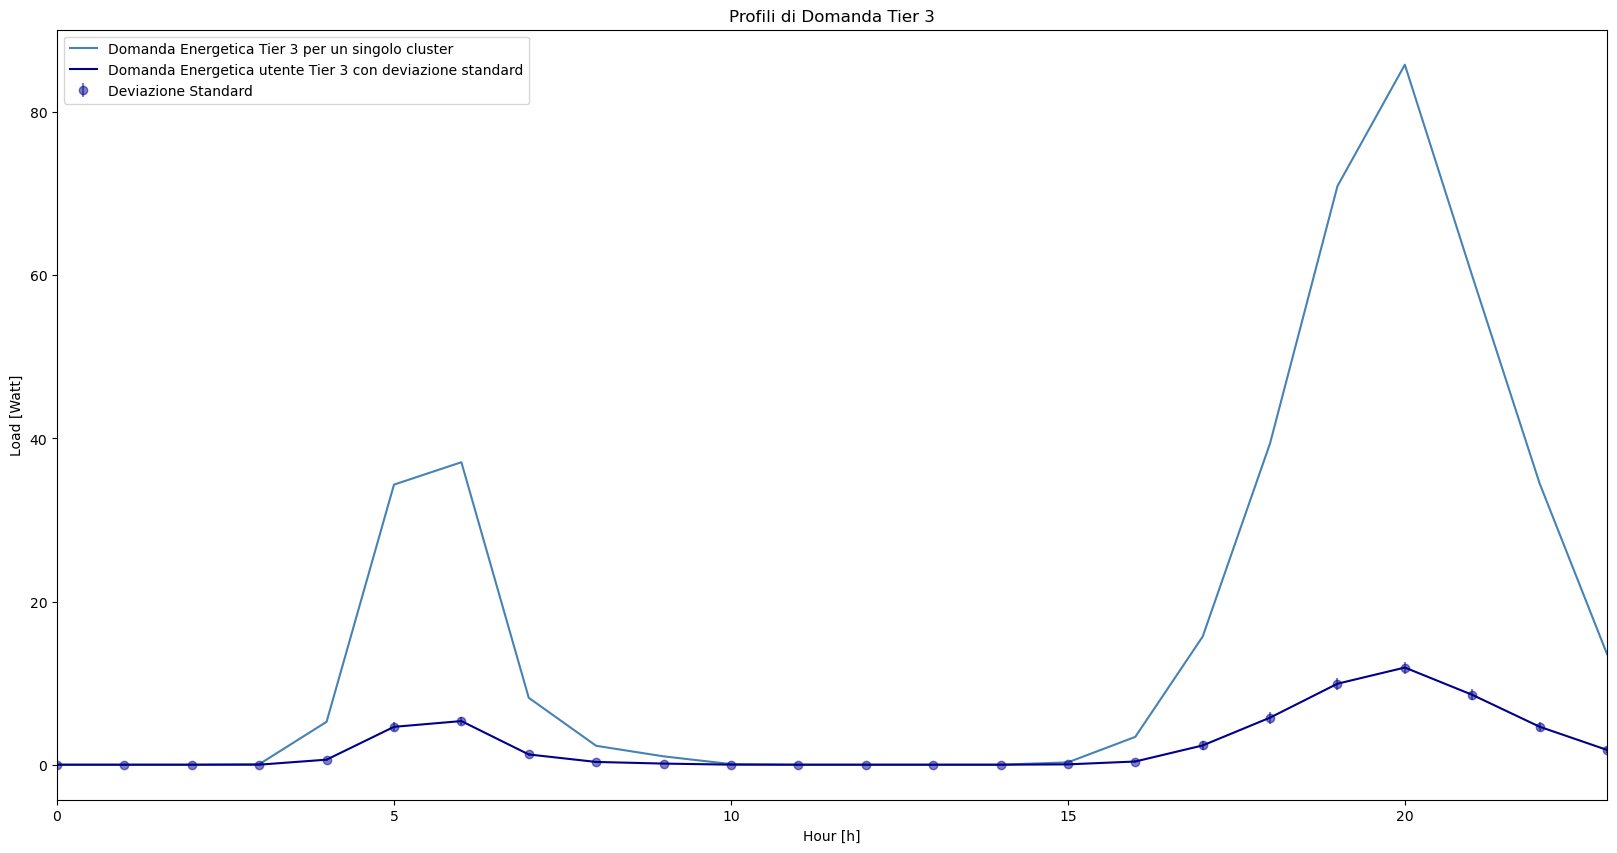

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel(
    "C:/Users/margh/Desktop/tesi/pypsa-distribution/resources/ramp/daily_type_demand_Tier1.xlsx"
)
load = load_df["tier_1"].values * 1000000
load = pd.DataFrame(load, columns=["Domanda Energetica Tier 3 per un singolo cluster"])

fig, ax = plt.subplots(figsize=(20, 10))

# Traccia la curva del carico
load.plot(
    ax=ax,
    label="Domanda Energetica Tier 3 per un singolo cluster",
    color="steelblue",
    legend=True,
)

# Traccia la curva del carico medio con deviazione standard
df["mean"].plot(
    ax=ax,
    label="Domanda Energetica utente Tier 3 con deviazione standard",
    color="darkblue",
    legend=True,
)

# Aggiungi la barra di errore
ax.errorbar(
    df.index,
    df["mean"],
    yerr=df["std"],
    fmt="o",
    color="darkblue",
    alpha=0.5,
    label="Deviazione Standard",
)

# Imposta le etichette degli assi
ax.set_xlabel("Hour [h]")
ax.set_ylabel("Load [Watt]")

# Imposta i limiti dell'asse X per mostrare dalle ore 0 alle ore 24
ax.set_xlim(0, 23)

# Imposta il titolo del grafico
ax.set_title("Profili di Domanda Tier 3")

# Posiziona la legenda
ax.legend(loc="best")

plt.show()

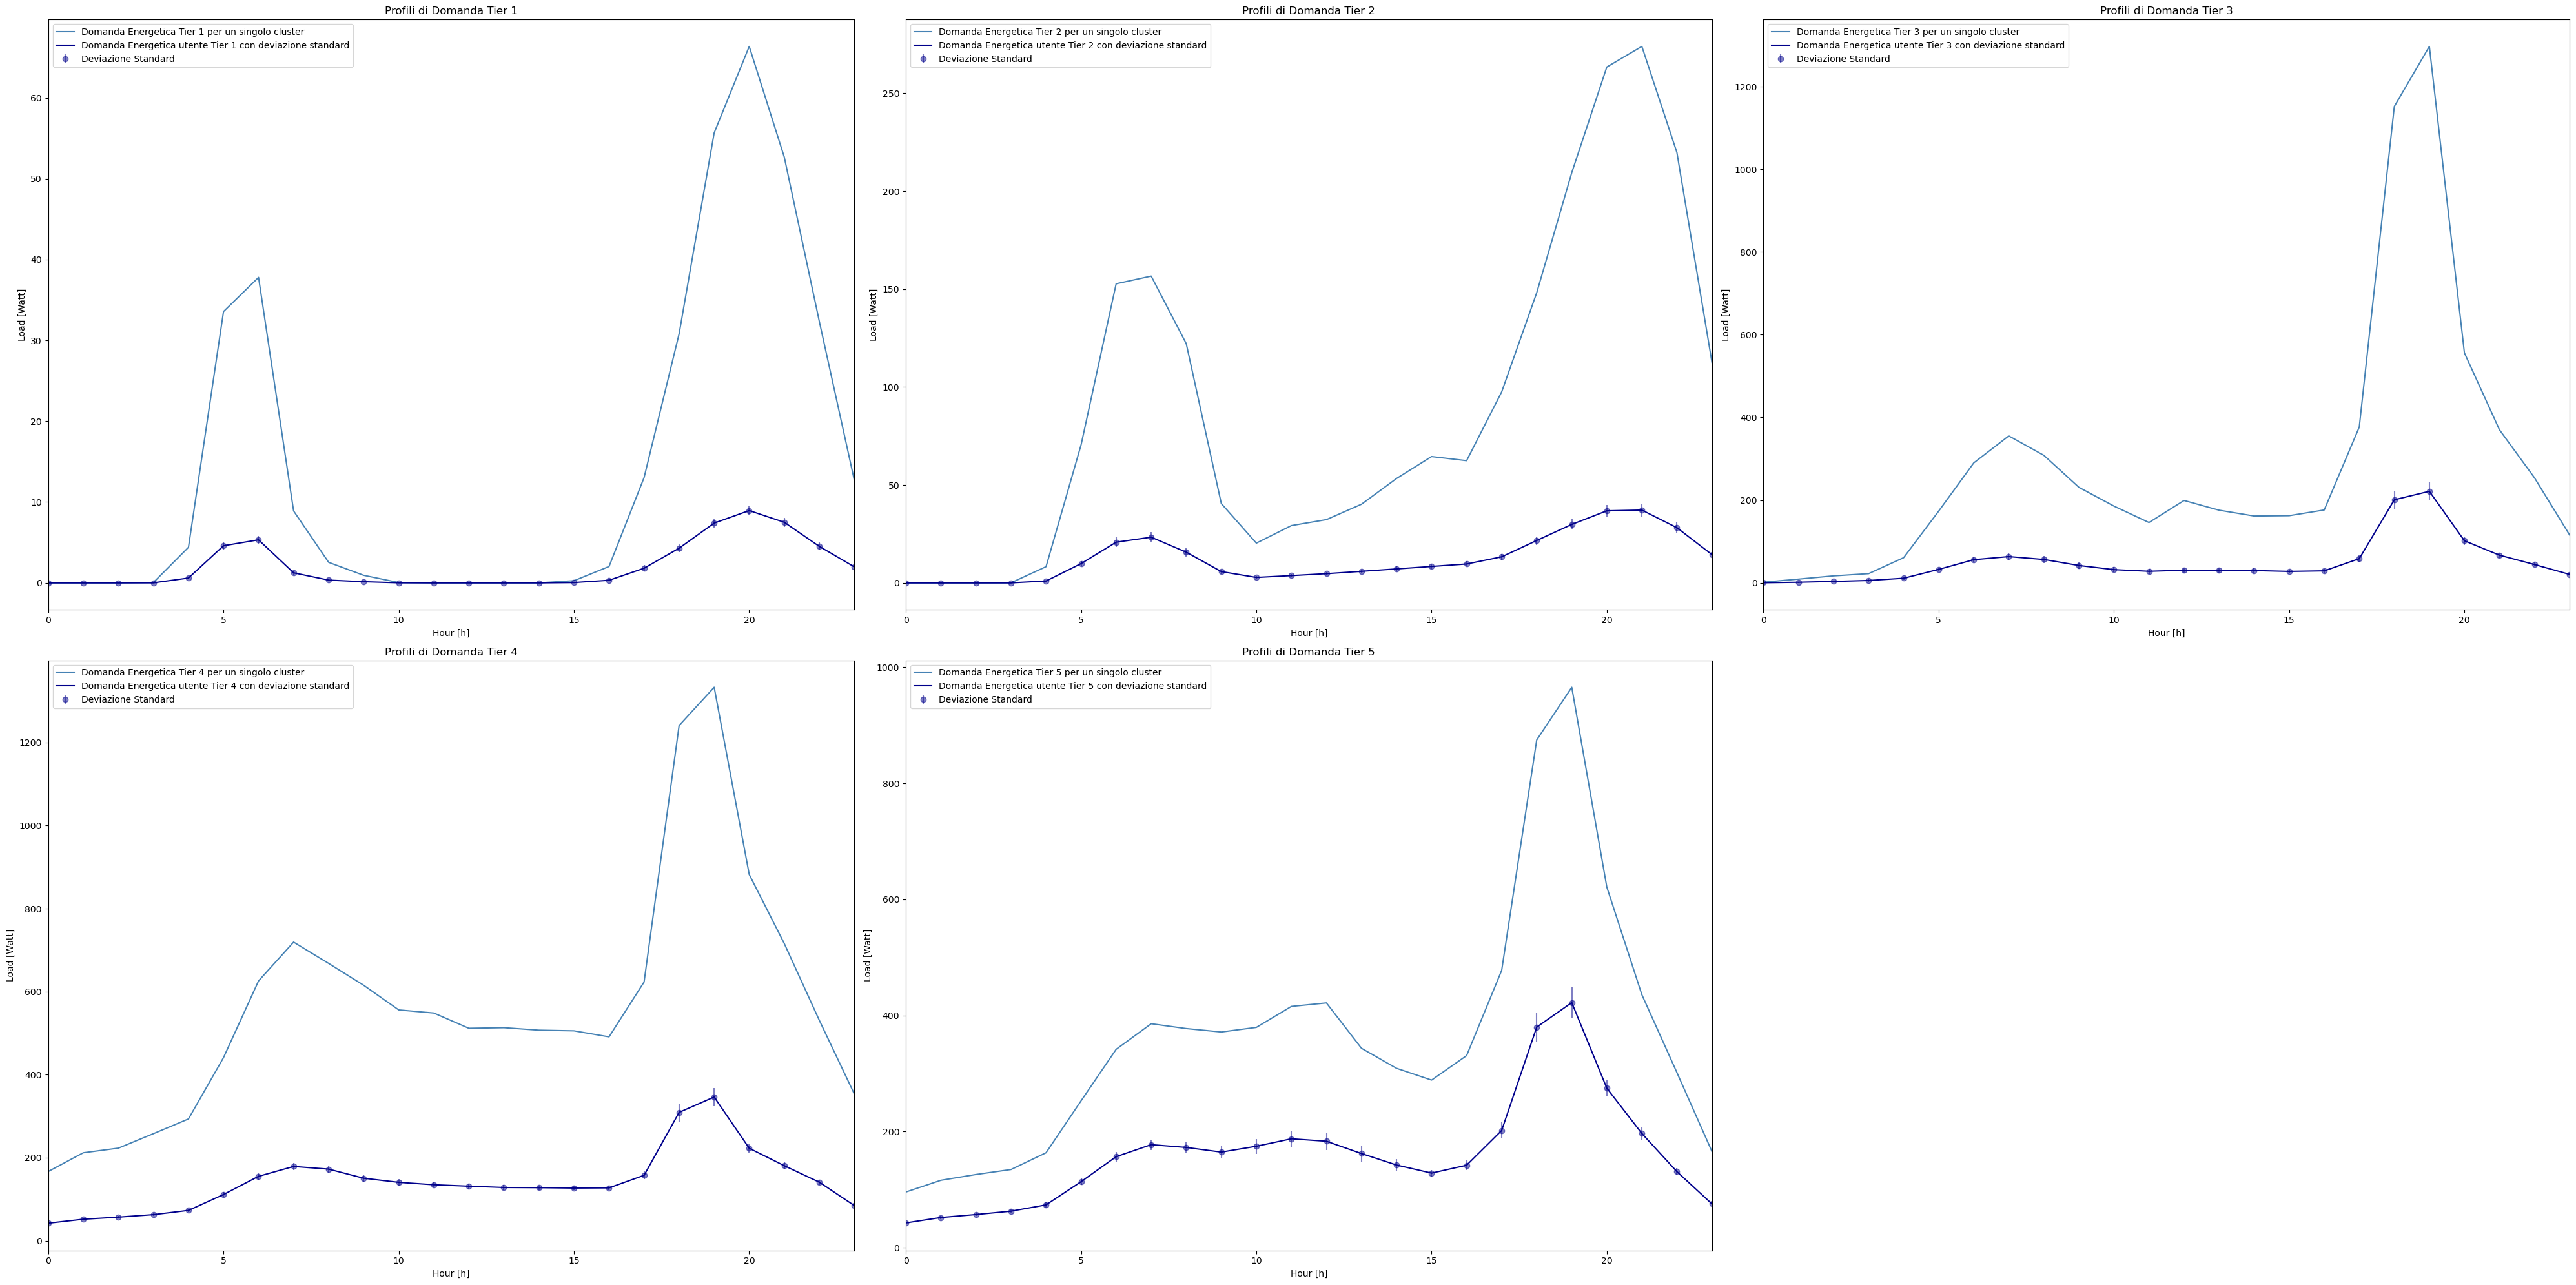

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Lista dei tier
tiers = [1, 2, 3, 4, 5]

# Crea la figura e la griglia di subplot (2x3 per avere 6 spazi, l'ultimo rimarrà vuoto)
fig, axs = plt.subplots(2, 3, figsize=(40, 20))

# Itera sui tiers
for i, tier in enumerate(tiers):
    # Carica il file Excel corrispondente
    df = pd.read_excel(
        f"C:/Users/margh/Desktop/tesi/pypsa-distribution/resources/ramp/daily_type_demand_Tier{tier}.xlsx"
    )
    def1 = pd.read_excel(
        f"C:/Users/margh/Desktop/tesi/pypsa-distribution/resources/ramp/daily_demand_Tier{tier}.xlsx"
    )

    # Crea il DataFrame del carico
    load = load_df[f"tier_{tier}"].values * 1000000
    load = pd.DataFrame(
        load, columns=[f"Domanda Energetica Tier {tier} per un singolo cluster"]
    )

    # Seleziona il subplot corrente
    ax = axs[i // 3, i % 3]

    # Traccia la curva del carico
    load.plot(
        ax=ax,
        label=f"Domanda Energetica Tier {tier} per un singolo cluster",
        color="steelblue",
        legend=True,
    )

    # Traccia la curva del carico medio con deviazione standard
    df["mean"].plot(
        ax=ax,
        label=f"Domanda Energetica utente Tier {tier} con deviazione standard",
        color="darkblue",
        legend=True,
    )
    # Aggiungi la barra di errore
    ax.errorbar(
        df.index,
        df["mean"],
        yerr=df["std"],
        fmt="o",
        color="darkblue",
        alpha=0.5,
        label="Deviazione Standard",
    )

    # Imposta le etichette degli assi
    ax.set_xlabel("Hour [h]")
    ax.set_ylabel("Load [Watt]")

    # Imposta i limiti dell'asse X per mostrare dalle ore 0 alle ore 24
    ax.set_xlim(0, 23)

    # Imposta il titolo del grafico
    ax.set_title(f"Profili di Domanda Tier {tier}")

    # Posiziona la legenda
    ax.legend(loc="best")

# Rimuovi l'ultimo subplot vuoto (se necessario)
fig.delaxes(axs[1, 2])


# Mostra il grafico
plt.tight_layout()
plt.show()

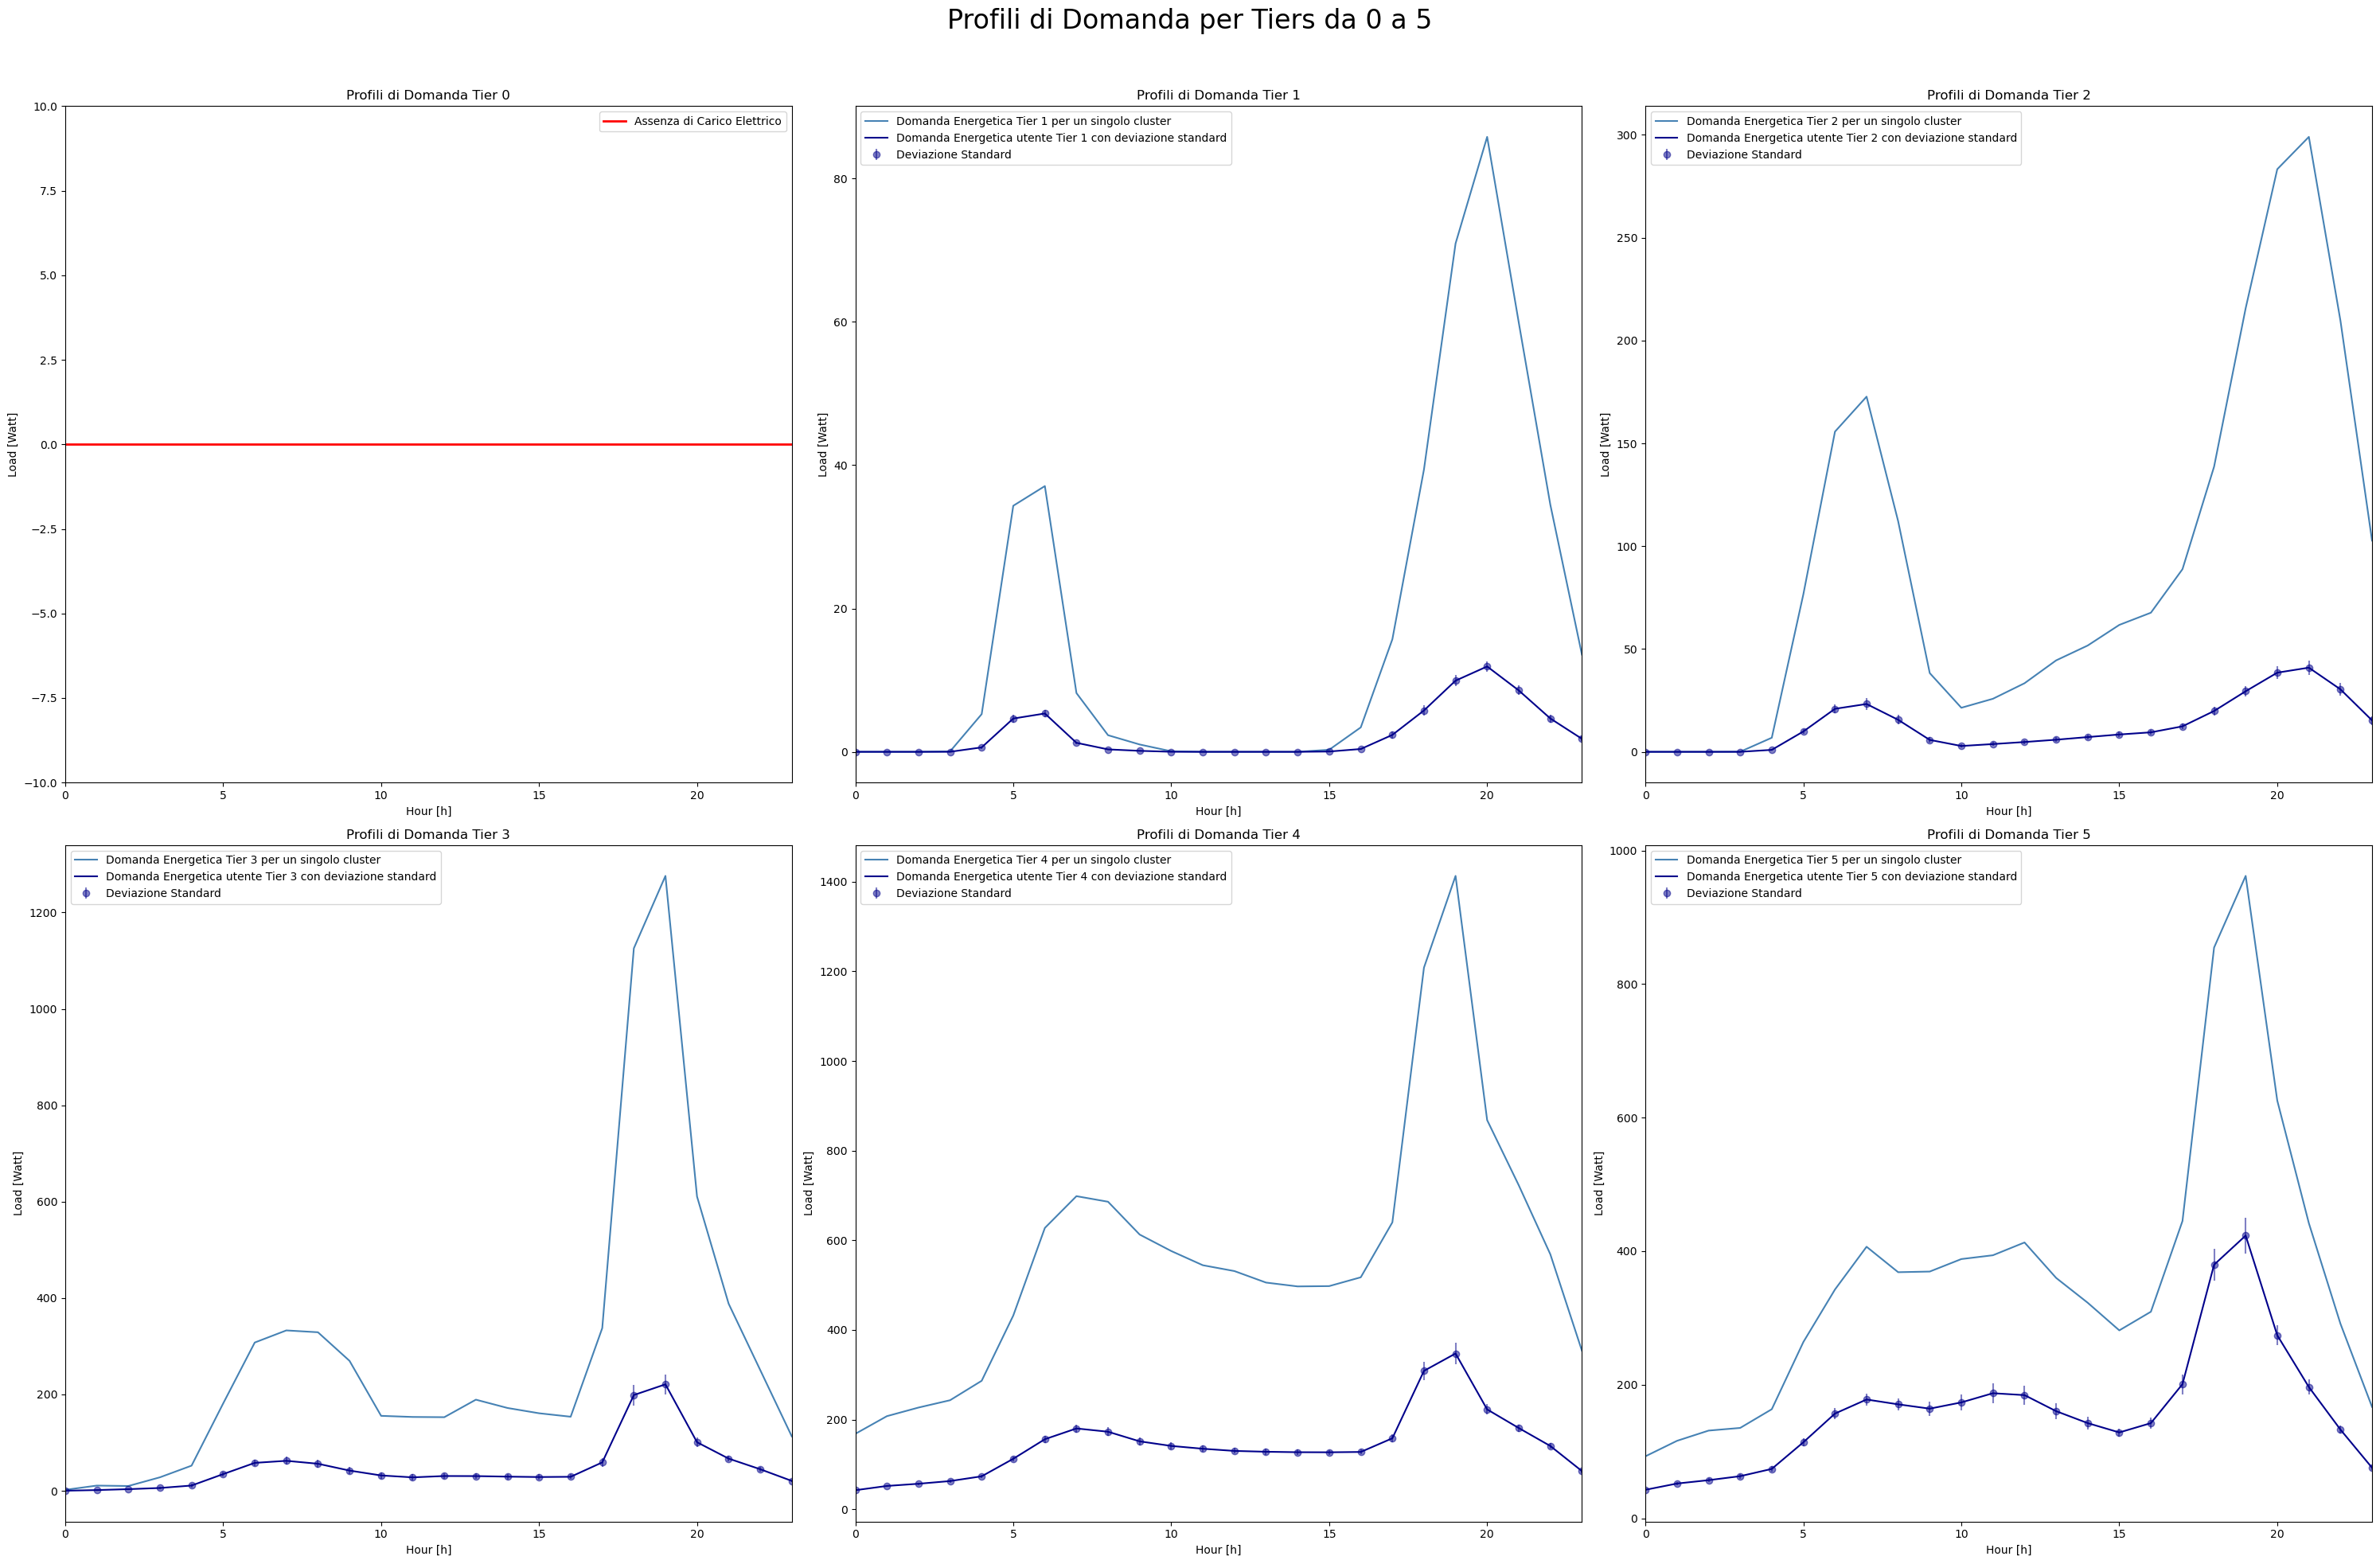

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Lista dei tier, inclusa la nuova entry per il Tier 0
tiers = [0, 1, 2, 3, 4, 5]

# Crea la figura e la griglia di subplot (2x3 per avere 6 spazi)
fig, axs = plt.subplots(2, 3, figsize=(30, 20))

# Itera sui tiers
for i, tier in enumerate(tiers):
    # Se tier è 0, crea una linea piatta sullo zero
    if tier == 0:
        ax = axs[i // 3, i % 3]
        ax.plot(
            range(24),
            [0] * 24,
            label="Assenza di Carico Elettrico",
            color="red",
            linewidth=2,
        )
        ax.set_xlabel("Hour [h]")
        ax.set_ylabel("Load [Watt]")
        ax.set_xlim(0, 23)
        ax.set_ylim(-10, 10)
        ax.set_title("Profili di Domanda Tier 0")
        ax.legend(loc="best")
    else:
        # Carica il file Excel corrispondente
        df = pd.read_excel(
            f"C:/Users/margh/Desktop/tesi/pypsa-distribution/resources/ramp/daily_type_demand_Tier{tier}.xlsx"
        )

        # Crea il DataFrame del carico
        load = load_df[f"tier_{tier}"].values * 1000000
        load = pd.DataFrame(
            load, columns=[f"Domanda Energetica Tier {tier} per un singolo cluster"]
        )

        # Seleziona il subplot corrente
        ax = axs[i // 3, i % 3]

        # Traccia la curva del carico
        load.plot(
            ax=ax,
            label=f"Domanda Energetica Tier {tier} per un singolo cluster",
            color="steelblue",
            legend=True,
        )

        # Traccia la curva del carico medio con deviazione standard
        df["mean"].plot(
            ax=ax,
            label=f"Domanda Energetica utente Tier {tier} con deviazione standard",
            color="darkblue",
            legend=True,
        )

        # Aggiungi la barra di errore
        ax.errorbar(
            df.index,
            df["mean"],
            yerr=df["std"],
            fmt="o",
            color="darkblue",
            alpha=0.5,
            label="Deviazione Standard",
        )

        # Imposta le etichette degli assi
        ax.set_xlabel("Hour [h]")
        ax.set_ylabel("Load [Watt]")

        # Imposta i limiti dell'asse X per mostrare dalle ore 0 alle ore 24
        ax.set_xlim(0, 23)

        # Imposta il titolo del grafico
        ax.set_title(f"Profili di Domanda Tier {tier}")

        # Posiziona la legenda
        ax.legend(loc="best")

# Aggiungi un titolo complessivo alla figura
fig.suptitle("Profili di Domanda per Tiers da 0 a 5", fontsize=24)

# Migliora il layout della figura
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Mostra il grafico
plt.show()